Classify person based on the Skeleton INFO as generated by openPose

In [ ]:
!ln -sf /content/drive/MyDrive/ConvertedGaitData/Stabalized/front/pose /content/pose

In [ ]:
import os
import json
import numpy as np

# Initialize an empty list to store the pose data arrays
pose_data_list = []

# Define the path to the main directory
main_dir = '/content/pose'

# Traverse through all the subdirectories in the main directory
for sub_dir in os.listdir(main_dir):
    json_path = os.path.join(main_dir, sub_dir, 'json')

    # Check if the json_path exists and is a directory
    if os.path.isdir(json_path):
        pose_sub_list = []
        for json_file in os.listdir(json_path):
            file_path = os.path.join(json_path, json_file)

            # Read the JSON file and extract the pose data
            with open(file_path, 'r') as f:
                pose_data = json.load(f)

                # Convert the pose data to a NumPy array and append it to the list
                pose_data_array = np.array(pose_data)
                pose_sub_list.append(pose_data_array)
        pose_sub_array = np.concatenate(pose_sub_list,axis=0)
        pose_data_list.append(pose_sub_array)

# Output the shape of the stacked array to verify
print(f'Stacked Pose Data Shape: {len(pose_data_list)}')


Stacked Pose Data Shape: 25


In [ ]:
def drop_labels_with_few_instances(X, Y, n):
    # Count the instances of each label
    unique, counts = np.unique(Y, return_counts=True)
    label_counts = dict(zip(unique, counts))

    # Identify labels with at least n instances
    labels_to_keep = [label for label, count in label_counts.items() if count >= n]

    # Filter the arrays to keep only those labels
    indices_to_keep = np.isin(Y, labels_to_keep)
    filtered_X = X[indices_to_keep]
    filtered_Y = Y[indices_to_keep]

    # Create a mapping from original labels to new sequential labels
    label_mapping = {label: i for i, label in enumerate(labels_to_keep)}

    # Apply the mapping to the label array
    mapped_Y = np.array([label_mapping[label] for label in filtered_Y])

    return filtered_X, mapped_Y

Distinct Temporal snippets

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize lists to store features (X) and labels (Y)
X = []
Y = []

# Iterate over each class in the pose_data_list
for class_label, pose_array in enumerate(pose_data_list):
    num_slices = pose_array.shape[0] // 23  # Total slices of size (23, 25, 3)

    for i in range(num_slices):
        # Extract a slice of size (23, 25, 3) from the first dimension
        start_slice = i*23
        slice_23 = pose_array[start_slice:start_slice+23, :, :]

        # Append the slice to X and the label to Y
        X.append(slice_23)
        Y.append(class_label)

# Convert X and Y lists to NumPy arrays for further processing
X = np.array(X)
Y = np.array(Y)
filtered_X, filtered_Y = drop_labels_with_few_instances(X, Y, 20)
# Split the data into training and testing sets without overlap
X_train, X_test, Y_train, Y_test = train_test_split(filtered_X, filtered_Y, test_size=0.2, random_state=42)

# Output the shapes of the training and testing sets to verify
print(f'Training Features Shape: {X_train.shape}')
print(f'Training Labels Shape: {Y_train.shape}')
print(f'Testing Features Shape: {X_test.shape}')
print(f'Testing Labels Shape: {Y_test.shape}')


Training Features Shape: (308, 23, 25, 3)
Training Labels Shape: (308,)
Testing Features Shape: (78, 23, 25, 3)
Testing Labels Shape: (78,)


In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100)
model.fit(X_train.reshape(X_train.shape[0],-1), Y_train)
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       0.83      0.71      0.77         7
           4       1.00      1.00      1.00         6
           5       0.67      1.00      0.80         4
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         4
          11       0.67      1.00      0.80         2
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         4
          14       1.00      0.67      0.80         3
          15       0.67      0.80      0.73         5
          16       1.00      0.25      0.40         4

    accuracy              

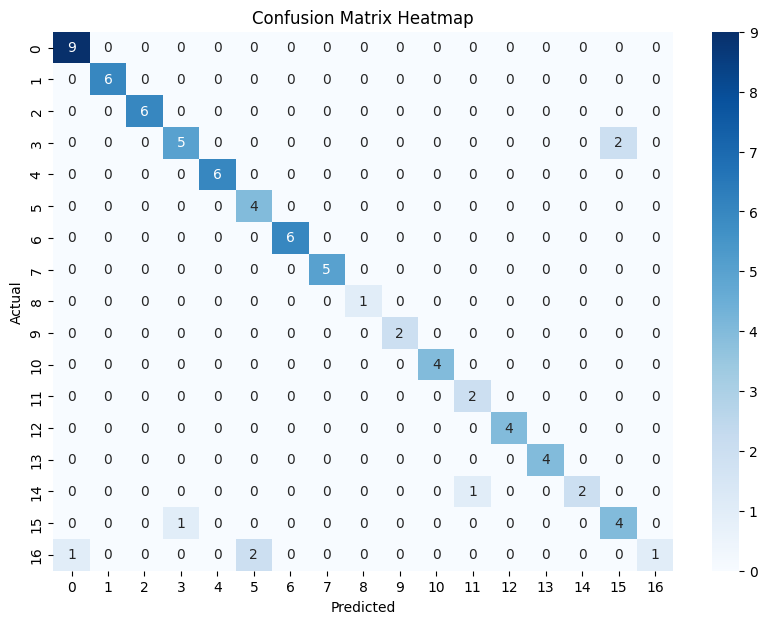

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()


Using Data Augmentation

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

test_size = 0.2
filter_n = 150
# Initialize lists to store features (X) and labels (Y)
X_train, X_test = [], []
Y_train, Y_test = [], []

# Iterate over each class in the pose_data_list
for class_label, pose_array in enumerate(pose_data_list):
    total_length = pose_array.shape[0]
    test_length = int(test_size * total_length)

    # Generate a random start index for the test slice
    test_start_idx = np.random.randint(0, total_length - test_length + 1)

    # Extract the test slice
    test_slice = pose_array[test_start_idx:test_start_idx + test_length]

    # The remaining part of the array is for training
    train_slice = np.concatenate((pose_array[:test_start_idx], pose_array[test_start_idx + test_length:]), axis=0)

    # Apply sliding window to the training slice
    num_train_slices = train_slice.shape[0] - 22
    if num_train_slices<filter_n:
      continue
    for i in range(num_train_slices):
        slice_23 = train_slice[i:i + 23, :, :]
        X_train.append(slice_23)
        Y_train.append(class_label)

    # Apply sliding window to the test slice
    num_test_slices = test_slice.shape[0] - 22
    for i in range(num_test_slices):
        slice_23 = test_slice[i:i + 23, :, :]
        X_test.append(slice_23)
        Y_test.append(class_label)


unique = np.unique(Y_train)

# Identify labels with at least n instances
labels_to_keep = [label for label in unique]

# Create a mapping from original labels to new sequential labels
label_mapping = {label: i for i, label in enumerate(labels_to_keep)}
# Apply the mapping to the label array
mapped_Y_train = np.array([label_mapping[label] for label in Y_train])
mapped_Y_test = np.array([label_mapping[label] for label in Y_test])

# Convert X and Y lists to NumPy arrays for further processing
X_train = np.array(X_train)
Y_train = np.array(mapped_Y_train)
X_test = np.array(X_test)
Y_test = np.array(mapped_Y_test)

# Output the shapes of the training and testing sets to verify
print(f'Training Features Shape: {X_train.shape}')
print(f'Training Labels Shape: {Y_train.shape}')
print(f'Testing Features Shape: {X_test.shape}')
print(f'Testing Labels Shape: {Y_test.shape}')


Training Features Shape: (8061, 23, 25, 3)
Training Labels Shape: (8061,)
Testing Features Shape: (1657, 23, 25, 3)
Testing Labels Shape: (1657,)


In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100)
model.fit(X_train.reshape(X_train.shape[0],-1), Y_train)
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       1.00      1.00      1.00       124
           2       0.64      0.98      0.78        65
           3       1.00      1.00      1.00        80
           4       1.00      1.00      1.00        80
           5       0.99      1.00      0.99        83
           6       1.00      0.64      0.78        89
           7       1.00      1.00      1.00        80
           8       0.99      1.00      0.99        78
           9       1.00      1.00      1.00        64
          10       1.00      1.00      1.00        72
          11       1.00      1.00      1.00        74
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00        89
          14       1.00      1.00      1.00        82
          15       1.00      0.99      0.99        82
          16       1.00      1.00      1.00        74
          17       1.00    

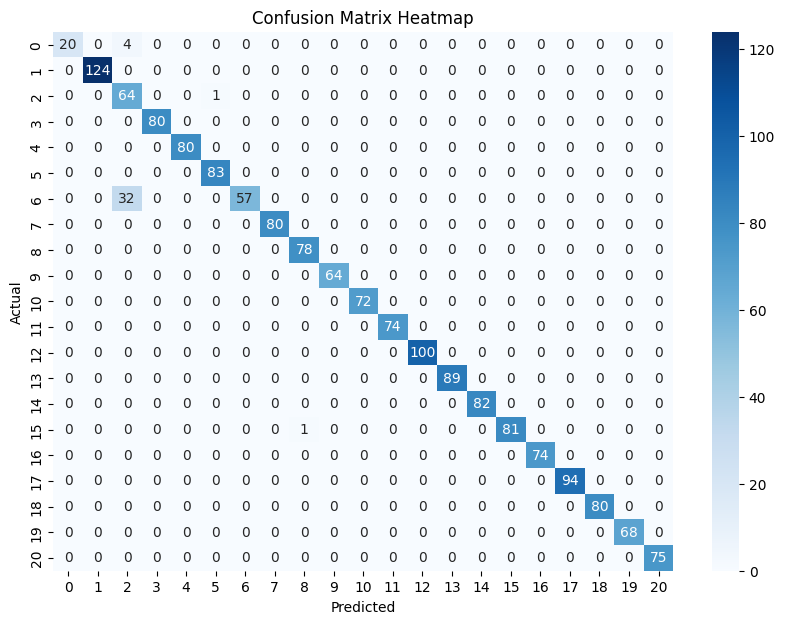

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()
